In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from scipy.stats import skew

pd.options.display.max_columns = 500

Будем предсказывать цены на недвижимость из [датасета с каггла](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/)! В качестве основной метрики для валидации моделей будем использовать, как и ранее, `MSLE`.

P.S. в данной работе при построении любых моделей, использующих недетерменированные элементы (как бутстрап), в алгоритме указываем параметр `random_state = 1` для воспроизводимости результатов.

In [3]:
df = pd.read_csv('csv_files/train_houses_reg.csv')
df = df.drop('Id', axis = 1)
df.head(5)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
df.shape

(1460, 80)

* SalePrice — цена продажи недвижимости в долларах. Это целевая переменная, которую вы пытаетесь предсказать.
* MSSubClass : Класс зданий
* MSZoning : Общая классификация зонирования.
* Фасад участка : длина улицы, прилегающей к участку (в погонных футах).
* Площадь участка : Размер участка в квадратных футах
* Улица : Тип подъездной дороги
* Переулок : Тип доступа через переулок
* Форма участка : Общая форма земельного участка.
* Контур местности : Ровность участка
* Коммунальные услуги : Виды доступных коммунальных услуг
* LotConfig : Конфигурация лота
* LandSlope : Уклон участка
* Район : Физические объекты в пределах городской черты Эймса.
* Условие 1 : Близость к главной дороге или железной дороге.
* Условие 2 : Близость к главной дороге или железной дороге (если таковая имеется).
* Тип здания : Тип жилого помещения
* HouseStyle : Стиль жилища
* Общая оценка : Общее качество материалов и отделки.
* Общее состояние : Общая оценка состояния
* Год постройки : Дата начала строительства
* YearRemodAdd : Дата реконструкции
* Тип крыши : Тип кровли
* Кровельные материалы : Кровельный материал
* Exterior1st : Внешнее покрытие дома
* Exterior2nd : Внешняя отделка дома (если используется более одного материала).
* MasVnrType : Тип облицовки из кирпичной кладки
* MasVnrArea : Площадь облицовки из кирпича в квадратных футах
* ExterQual : Качество наружных материалов
* ExterCond : Текущее состояние материала на внешней поверхности.
* Фундамент : Тип фундамента
* BsmtQual : Высота подвала
* BsmtCond : Общее состояние подвала
* BsmtExposure : Стены подвала с выходом на улицу или на уровне сада.
* BsmtFinType1 : Качество отделки подвального помещения
* BsmtFinSF1 : Тип 1, готовая площадь в квадратных футах
* BsmtFinType2 : Качество второй обработанной зоны (если таковая имеется)
* BsmtFinSF2 : Тип 2, готовая площадь в квадратных футах
* BsmtUnfSF : Недостроенная площадь подвального помещения в квадратных футах.
* TotalBsmtSF : Общая площадь подвального помещения в квадратных футах.
* Отопление : Тип отопления
* HeatingQC : Качество и состояние отопления
* CentralAir : Центральное кондиционирование воздуха
* Электрика : Электрическая система
* 1stFlrSF : Площадь первого этажа в квадратных футах
* 2ndFlrSF : Площадь второго этажа в квадратных футах
* LowQualFinSF : Низкое качество отделки (все этажи)
* GrLivArea : Площадь жилого пространства над уровнем земли (в квадратных футах).0
* BsmtFullBath : Полностью оборудованные ванные комнаты в подвале
* BsmtHalfBath : Туалеты в подвале
* Ванная комната : Полностью оборудованные ванные комнаты расположены над уровнем земли.
* Туалет : Туалеты расположены над уровнем земли.
* Спальня : Количество спален, расположенных выше цокольного этажа.
* Кухня : Количество кухонь
* KitchenQual : Качество кухни
* TotRmsAbvGrd : Общее количество комнат над уровнем земли (без учета ванных комнат).
* Функциональность : Оценка функциональности дома
* Камины : Количество каминов
* FireplaceQu : Качество камина
* Тип гаража : Местоположение гаража
* GarageYrBlt : Год постройки гаража
* GarageFinish : Внутренняя отделка гаража.
* GarageCars : Размер гаража вместимостью автомобилей
* Площадь гаража : Размер гаража в квадратных футах.
* GarageQual : Качество гаража
* Состояние гаража : Состояние гаража
* Мощеная подъездная дорога : Мощеная подъездная дорога
* WoodDeckSF : Площадь деревянной террасы в квадратных футах
* OpenPorchSF : Площадь открытой веранды в квадратных футах
* Закрытая веранда : площадь закрытой веранды в квадратных футах.
* 3SsnPorch : Площадь веранды для использования в течение трех сезонов (в квадратных футах).
* Застекленная веранда : площадь застекленной веранды в квадратных футах.
* Площадь бассейна : Площадь бассейна в квадратных футах
* PoolQC : Качество бассейнов
* Забор : Качество забора
* Разные функции : Дополнительные функции, не охваченные другими категориями.
* MiscVal : $Value of miscellaneous feature
* MoSold : Месяц продаж
* Год продажи : Год продажи
* SaleType : Тип продажи
* Условия продажи : Условия продажи

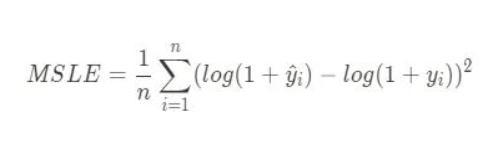

In [5]:
### Разделим выборку на объекты-таргеты

y = df['SalePrice']
X = df.drop(columns=['SalePrice'])

### Логарифмируем таргет для будущей оптимизации
### MSLE через MSE

log_target = np.log1p(y)

In [6]:
display(X)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal
1456,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal
1457,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,NaN,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal
1458,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,GasA,Gd,Y,FuseA,1078,0,0,1078,1,0,1,0,2,1,Gd,5,Typ,0,NaN,Attchd,1950.0,Unf,1,240,TA,TA,Y,366,0,112,0,0,0,NaN,NaN,Na

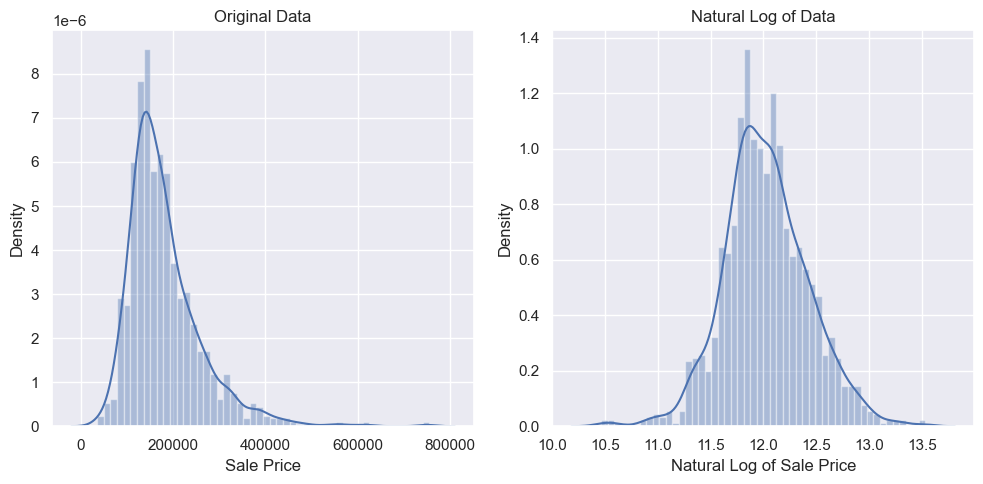

In [7]:
### Это позволяет получить нормальное распределение таргета
### Важно, например, для построения корректной
### С точки зрения статистических свойств
### Линейной модели.
### Хотя здесь мы будем строить ансамбли деревьев, 
### И это не особо интересно.

sns.set(rc={'figure.figsize':(15,10)})

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.distplot(y, bins=50)
plt.title('Original Data')
plt.xlabel('Sale Price')

plt.subplot(1,2,2)
sns.distplot(log_target, bins=50)
plt.title('Natural Log of Data')
plt.xlabel('Natural Log of Sale Price')
plt.tight_layout()



### В начале поработаем с пропусками!

Если в какой-либо колонке оказывается достаточно много пропусков, обычно советуют от них избавляться. Мотивировано это тем, что в таких фичах мы можем наблюдать серьезный недостаток информативности, а заполнение пропусков может лишь внести лишнего шума в данные.

Избавились от всех колонок, в которых пропусков оказывается больше 15%. (1б)

In [8]:
X.columns[X.isnull().any()]

Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

In [9]:
### Your code is here
cols_to_drop = X.columns[X.isna().mean() > 0.15]
X = X.drop(columns=cols_to_drop)


Вещественные колонки заполните медианным значением по фиче, а категориальные - самой популярной по колонке категорией. (2б)

Заметим, что колонки `MoSold`, `YrSold`, `GarageYrBlt`, `YearBuilt`, `YearRemodAdd` хоть в таблице не являются типами `object`, вряд ли их справедливо использовать как вещественные. Обработали их как категориальные.

In [10]:
### Your code is here
print(X.dtypes)

cat_col= ['MoSold', 'YrSold', 'GarageYrBlt', 'YearBuilt', 'YearRemodAdd']
X[cat_col] = X[cat_col].astype('object')

print(X.dtypes)


MSSubClass        int64
MSZoning         object
LotArea           int64
Street           object
LotShape         object
                  ...  
MiscVal           int64
MoSold            int64
YrSold            int64
SaleType         object
SaleCondition    object
Length: 72, dtype: object
MSSubClass        int64
MSZoning         object
LotArea           int64
Street           object
LotShape         object
                  ...  
MiscVal           int64
MoSold           object
YrSold           object
SaleType         object
SaleCondition    object
Length: 72, dtype: object


In [11]:
numeric_columns = X.loc[:, X.dtypes != 'object'].columns
categorical_columns = X.loc[:, X.dtypes == 'object'].columns


for col in numeric_columns:
    X[col].fillna(X[col].median(), inplace=True)

for col in categorical_columns:
    X[col].fillna(X[col].mode()[0], inplace=True)



In [12]:
X.columns[X.isnull().any()]

Index([], dtype='object')

In [13]:
X.to_csv('X_new.csv', sep=',', index=False)

In [14]:
### Отложенная выборка

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    log_target, 
                                                    test_size=0.25, 
                                                    random_state=1)

Напишем трансформер, который будет делать следующее:

1. Масштабирование через StandardScaler для вещественных колонок
2. Кодирование через OneHotEncoder для категориальных, содержащих менее, чем 5 уникальных значений
3. Кодирование через TargetEncoder для всех остальных категориальных

Для этого воспользуемся библиотекой `category_encoders` помимо `sklearn`.

А так же классом `ColumnTransformer` из `sklearn.compose`.

P.S. для деревьев процедура StandardScaling не обязательна (решающие деревья нечувствительны к масштабу). Тем не менее, это может сделать обучение модели менее тяжелым (хранить большие числа сложно для задач с большим количеством данных).

In [15]:
cols_for_ohe = [x for x in categorical_columns if X[x].nunique() < 5]
cols_for_mte = [x for x in categorical_columns if X[x].nunique() >= 5]

cols_for_ohe_idx = [list(X.columns).index(col) for col in cols_for_ohe]
cols_for_mte_idx = [list(X.columns).index(col) for col in cols_for_mte]
numeric_cols_idx = [list(X.columns).index(col) for col in numeric_columns]

In [16]:
import sys
!{sys.executable} -m pip install category_encoders

In [17]:
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from category_encoders.one_hot import OneHotEncoder
from sklearn.preprocessing import StandardScaler

### Your code is here



t = [('OneHotEncoder', OneHotEncoder(), cols_for_ohe_idx),
     ('TargetEncoder', TargetEncoder(), cols_for_mte_idx),
     ('StandardScaler', StandardScaler(), numeric_cols_idx)]

col_transform = ColumnTransformer(transformers=t)

In [18]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

### Your code is here
pipe = Pipeline([('column_transformer', col_transform),
                 ('des_tree', DecisionTreeRegressor())])

pipe.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('column_transformer', ...), ('des_tree', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('OneHotEncoder', ...), ('TargetEncoder', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the outpu

In [19]:
#замерим качетсво работы одного решающего дерева на MSLE
train_preds = pipe.predict(X_train)
test_preds = pipe.predict(X_test)

train_error = np.mean((train_preds - y_train)**2)
test_error = np.mean((test_preds - y_test)**2)

print(f'Quality on train: {train_error:.3f}')
print(f'Quality on test: {test_error:.3f}')


Quality on train: 0.000
Quality on test: 0.049


Справляется даже без контроля переобучения!

Посмотрим на перформанс Случайного Леса! Подберем параметры по отложенной выборке по данной сетке `param_grid`. 

In [1]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "random_forest__max_depth": [10, 15, 20],
    "random_forest__min_samples_split": [2, 5, 10],
    "random_forest__min_samples_leaf": [1, 3, 5]
}

pipe_rf = Pipeline([('column_transformer', col_transform),
                    ('random_forest', RandomForestRegressor())])

search = GridSearchCV(pipe_rf,
                      param_grid,
                      scoring='neg_mean_squared_error')

search.fit(X_train, y_train)

print(f'Best parametrs with best score = {search.best_score_:.3f}:')
print(search.best_params_)

print(f'Quality of the best model in final test: {search.score(X_test, y_test):.3f}')




NameError: name 'Pipeline' is not defined

Попробуем теперь поэкспериментировать с бэггингами. 

Построим бэггинги с 100 базовыми моделями (и остальными стандартными параметрами) над линейной регрессией, деревом и случайным лесом (бэггинг над бэггингом!). 

Посмотрим на качество у каждой модели на тесте и выявим какой алгоритм получился лучше с точки зрения качества на тесте

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor

### Your code is here
pipe_lr = Pipeline([('column_transformer', col_transform),
                    ('lr', LinearRegression())])

pipe_tree = Pipeline([('column_transformer', col_transform),
                      ('des_tree', DecisionTreeRegressor())])

pipe_forest = Pipeline([('column_transformer', col_transform),
                        ('random_forest', RandomForestRegressor())])

bagging_lr = BaggingRegressor(estimator=pipe_lr, n_estimators=100)
bagging_tree = BaggingRegressor(estimator=pipe_tree, n_estimators=100)
bagging_forest = BaggingRegressor(estimator=pipe_forest, n_estimators=100)



In [23]:
from sklearn.metrics import mean_squared_error

bagging_lr.fit(X_train, y_train)

test_lr_preds = bagging_lr.predict(X_test)
test_lr_error = mean_squared_error(y_test, test_lr_preds)
print(f"MSLE Linear Regression: {test_lr_error:.3f}")


bagging_tree.fit(X_train, y_train)

test_tree_preds = bagging_tree.predict(X_test)
test_tree_error = mean_squared_error(y_test, test_tree_preds)
print(f"MSLE Decition tree: {test_tree_error:.3f}")


bagging_forest.fit(X_train, y_train)

test_forest_preds = bagging_forest.predict(X_test)
test_forest_error = mean_squared_error(y_test, test_forest_preds)
print(f"MSLE Random forest: {test_forest_error:.3f}")


MSLE Linear Regression: 0.018
MSLE Decition tree: 0.019
MSLE Random forest: 0.019


### Добавим новые фичи!

Создадим следующие четыре новые вещественные фичи:

1. Отношения площади 1 этажа к общей площади (колонки 1stFlrSF и GrLivArea, в %)
2. Отношение Площади завершенного фундамента первого типа к общей площади фундамента (колонки BsmtFinSF1 и TotalBsmtSF, в %)
3. Возраст дома (между YearBuilt и YrSold)
4. Общая площадь самого дома и фундамента/цоколя (1stFlrSF + 2ndFlrSF + TotalBsmtSF)

Обучим заново Случайный лес и найдём лучшие гиперпараметры на старой сетке.



In [24]:
### Your code is here
X['GrLivArea'].isna().sum()


0

In [25]:
#Отношения площади 1 этажа к общей площади (колонки 1stFlrSF и GrLivArea, в %)
X['feature_1'] = X["1stFlrSF"] * 100 / X["GrLivArea"]
#Отношение Площади завершенного фундамента первого типа к общей площади фундамента (колонки BsmtFinSF1 и TotalBsmtSF, в %)
def bsmt_finish(x):
    
    if x["TotalBsmtSF"] == 0:
        return 0
    else:
        return x["BsmtFinSF1"] * 100 / x["TotalBsmtSF"]

X['feature_2'] = X.apply(bsmt_finish, axis=1)

#Возраст дома (между YearBuilt и YrSold)
def is_house_old(x):
    
    return int(x['YrSold']) - int(x['YearBuilt'])

X['feature_3'] = X.apply(is_house_old, axis=1)


#Общая площадь самого дома и фундамента/цоколя (1stFlrSF + 2ndFlrSF + TotalBsmtSF)
def total_sq(x):

     return x["1stFlrSF"] + x["2ndFlrSF"] + x['TotalBsmtSF']

X['feature_4'] = X.apply(total_sq, axis=1)



In [26]:
X.shape

(1460, 76)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    log_target, 
                                                    test_size=0.25, 
                                                    random_state=1)

In [28]:
param_grid = {
    "random_forest__max_depth": [10, 15, 20],
    "random_forest__min_samples_split": [2, 5, 10],
    "random_forest__min_samples_leaf": [1, 3, 5]
}

pipe_rf = Pipeline([('column_transformer', col_transform),
                    ('random_forest', RandomForestRegressor())])

search = GridSearchCV(pipe_rf,
                      param_grid,
                      scoring='neg_mean_squared_error')

search.fit(X_train, y_train)

print(f'Best parametrs with best score = {search.best_score_:.3f}:')
print(search.best_params_)

print(f'Quality of the best model in final test: {search.score(X_test, y_test):.3f}')



Best parametrs with best score = -0.022:
{'random_forest__max_depth': 20, 'random_forest__min_samples_leaf': 1, 'random_forest__min_samples_split': 2}
Quality of the best model in final test: -0.018
